# Somatotopic Decoding Analysis

**Dataset:**
- **Participant:** sub-p0001
- **Runs:** 4
- **Total samples:** 160
- **Electrodes:** 20 (E1-E20)
- **Samples per electrode:** 8

**BOLD Signal Preprocessing:**
- **Z-transform normalization:** Remove amplitude differences (amplitude has no physiological meaning)

**Leave-One-Run-Out Cross-Validation:** 4 folds, training on 3 runs (120 samples = 6 per electrode)

In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nilearn.image import load_img, index_img, mean_img, resample_to_img
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn.image import new_img_like
from nilearn import plotting
from nilearn.maskers import NiftiMasker

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

In [2]:
BIDS_ROOT = Path(r"C:/Users/duart/Desktop/Tese/Mapping_Tese/mapping_tese/data/BIDS-somatosensory/BIDS-somatosensory")
DERIVATIVES = BIDS_ROOT / "derivatives" / "fmriprep"

subjects = ["sub-p0001"]
session = "ses-01"
task = "task-S1Map"
space = "MNI152NLin2009cAsym"
n_runs_per_subject = 4


HRF_DELAY = 5.0
WINDOW = 1

bold_json = BIDS_ROOT / subjects[0] / session / "func" / f"{subjects[0]}_{session}_{task}_run-1_bold.json"
with open(bold_json, 'r', encoding='utf-8') as f:
    tr = float(json.load(f)["RepetitionTime"])
print(f"Subject: {subjects[0]}")
print(f"Runs: {n_runs_per_subject}")
print(f"TR: {tr} s")
print(f"HRF delay: {HRF_DELAY} s")
print(f"Window: {WINDOW} volumes")

Subject: sub-p0001
Runs: 4
TR: 2.0 s
HRF delay: 5.0 s
Window: 1 volumes


In [3]:
RESULTS_DIR = Path("results")
FIGURES_DIR = RESULTS_DIR / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_LOG = RESULTS_DIR / "analysis_log.txt"
log_file = open(OUTPUT_LOG, 'w', encoding='utf-8')

## Load Events from Both Subjects

In [4]:
all_events = []
subject = subjects[0]
for run in range(1, n_runs_per_subject + 1):
    events_path = BIDS_ROOT / subject / session / "func" / f"{subject}_{session}_{task}_run-{run}_events.tsv"
    df = pd.read_csv(events_path, sep='\t')
    df['subject'] = subject
    df['run'] = run
    all_events.append(df)

events_df = pd.concat(all_events, ignore_index=True)
stim_events = events_df[~events_df['trial_type'].isin(['Baseline', 'Jitter'])].copy()

print(f"Subject: {subject}")
print(f"Total events: {len(events_df)}")
print(f"Stimulation events: {len(stim_events)}")
print(f"Unique electrodes: {stim_events['trial_type'].nunique()}")
print(f"\nSamples per run:")
print(stim_events.groupby('run').size().to_dict())
print(f"\nSamples per electrode:")
electrode_counts = stim_events['trial_type'].value_counts().sort_index()
print(f"  Min: {electrode_counts.min()}, Max: {electrode_counts.max()}, Mean: {electrode_counts.mean():.1f}")

Subject: sub-p0001
Total events: 328
Stimulation events: 160
Unique electrodes: 20

Samples per run:
{1: 40, 2: 40, 3: 40, 4: 40}

Samples per electrode:
  Min: 8, Max: 8, Mean: 8.0


In [5]:
first_run_path = (DERIVATIVES / subjects[0] / session / "func" /
                  f"{subjects[0]}_{session}_{task}_run-1_space-{space}_desc-preproc_bold.nii.gz")
first_run_img = load_img(str(first_run_path))
ref_img = index_img(first_run_img, 0)
print(f"Reference image shape: {first_run_img.shape}")

atlas = fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
s1_indices = [i for i, lab in enumerate(atlas.labels) if 'Postcentral Gyrus' in str(lab) and i != 0]
if len(s1_indices) == 0 and 'Postcentral Gyrus' in atlas.labels:
    s1_indices = [atlas.labels.index('Postcentral Gyrus')]

atlas_img = atlas.maps
atlas_data = atlas_img.get_fdata()
mask_data = np.isin(atlas_data, s1_indices).astype('uint8')
s1_mask = new_img_like(atlas_img, mask_data)
s1_mask_resampled = resample_to_img(s1_mask, ref_img, interpolation='nearest', force_resample=True, copy_header=True)
masker = NiftiMasker(mask_img=s1_mask_resampled, standardize=False).fit()

print(f"\nS1 atlas indices: {s1_indices}")
print('Selected atlas regions:')
for i in s1_indices:
    print(f"  - {atlas.labels[i]}")
print(f"\nNumber of voxels in S1 mask: {int(np.sum(mask_data))}")

display = plotting.plot_roi(s1_mask_resampled, bg_img=ref_img, 
                            title='S1 ROI Mask (Postcentral Gyrus)',
                            display_mode='ortho', cut_coords=(0, -20, 60))
display.savefig(FIGURES_DIR / 's1_mask.png', dpi=150)
display.close()
print(f"\nS1 mask saved to: {FIGURES_DIR / 's1_mask.png'}")

Reference image shape: (121, 144, 121, 250)
[fetch_atlas_harvard_oxford] Dataset found in C:\Users\duart\nilearn_data\fsl

S1 atlas indices: [17]
Selected atlas regions:
  - Postcentral Gyrus

Number of voxels in S1 mask: 6895

S1 mask saved to: results\figures\s1_mask.png


In [6]:
feature_rows = []
labels = []
groups = []

subject = subjects[0] 
for run in range(1, n_runs_per_subject + 1):
    func_path = (DERIVATIVES / subject / session / "func" /
                 f"{subject}_{session}_{task}_run-{run}_space-{space}_desc-preproc_bold.nii.gz")
    img = load_img(str(func_path))
    run_length = img.shape[3]
    
    run_events = stim_events[
        (stim_events['subject'] == subject) & 
        (stim_events['run'] == run)
    ].sort_values('onset')
    
    print(f"{subject} run {run}: {img.shape}, {len(run_events)} events")

    for _, ev in run_events.iterrows():
        peak_vol = int(np.round((float(ev['onset']) + HRF_DELAY) / tr))
        if peak_vol >= run_length:
            continue

        vols = list(range(max(0, peak_vol - WINDOW), min(run_length, peak_vol + WINDOW + 1)))
        averaged = mean_img(index_img(img, vols), copy_header=True)
        row = masker.transform(averaged)
        feature_rows.append(row.ravel())
        labels.append(str(ev['trial_type']))
        groups.append(run)

X_features = np.vstack(feature_rows)
y = np.asarray(labels)
groups = np.asarray(groups)

print('\n' + '='*70)
print('FEATURE EXTRACTION SUMMARY')
print('='*70)
print(f'Subject: {subject}')
print(f'Feature matrix shape: {X_features.shape}')
print(f'Total samples: {len(y)}')
print(f'Number of classes: {len(np.unique(y))}')
print(f'Samples per electrode: {len(y) / len(np.unique(y)):.1f}')

logo = LeaveOneGroupOut()
n_folds = logo.get_n_splits(groups=groups)
samples_per_fold_train = (len(y) * (n_folds - 1)) / n_folds
samples_per_fold_test = len(y) / n_folds

print(f'\nCross-validation setup:')
print(f'  Method: Leave-One-Run-Out (LORO)')
print(f'  Number of folds: {n_folds}')
print(f'  Training samples per fold: {samples_per_fold_train:.0f} ({samples_per_fold_train / len(np.unique(y)):.1f} per electrode)')
print(f'  Test samples per fold: {samples_per_fold_test:.0f} ({samples_per_fold_test / len(np.unique(y)):.1f} per electrode)')
print('='*70)

sub-p0001 run 1: (121, 144, 121, 250), 40 events
sub-p0001 run 2: (121, 144, 121, 250), 40 events
sub-p0001 run 3: (121, 144, 121, 250), 40 events
sub-p0001 run 4: (121, 144, 121, 250), 40 events

FEATURE EXTRACTION SUMMARY
Subject: sub-p0001
Feature matrix shape: (160, 13434)
Total samples: 160
Number of classes: 20
Samples per electrode: 8.0

Cross-validation setup:
  Method: Leave-One-Run-Out (LORO)
  Number of folds: 4
  Training samples per fold: 120 (6.0 per electrode)
  Test samples per fold: 40 (2.0 per electrode)




Can individual electrodes be decoded from S1 activity patterns using Linear SVM with LORO cross-validation?

In [7]:
clf = LinearSVC(C=1.0, class_weight=None, dual='auto', max_iter=20000, random_state=RANDOM_SEED)
pipe = Pipeline(steps=[('scale', StandardScaler(with_mean=True, with_std=True)), ('clf', clf)])

all_classes = np.unique(y)
y_pred = np.empty_like(y, dtype=object)
fold_acc = []
fold_bacc = []

print("=" * 70)
print("20-WAY ELECTRODE CLASSIFICATION (LORO CV)")
print("=" * 70)

for fold_i, (train_idx, test_idx) in enumerate(logo.split(X_features, y, groups), 1):
    left_out = int(np.unique(groups[test_idx])[0])
    X_train = X_features[train_idx]
    X_test = X_features[test_idx]
    pipe.fit(X_train, y[train_idx])
    y_pred[test_idx] = pipe.predict(X_test)
    acc = accuracy_score(y[test_idx], y_pred[test_idx])
    bacc = balanced_accuracy_score(y[test_idx], y_pred[test_idx])
    fold_acc.append(acc)
    fold_bacc.append(bacc)
    y_true_fold = y[test_idx]
    y_pred_fold = y_pred[test_idx]
    n_correct = np.sum(y_true_fold == y_pred_fold)
    n_total = len(y_true_fold)
    
    print(f"\nFold {fold_i} (run {left_out}):")
    print(f"  Train samples: {len(train_idx)}, Test samples: {n_total}")
    print(f"  Correct predictions: {n_correct}/{n_total}")
    print(f"  Accuracy: {n_correct}/{n_total} = {acc:.4f}")
    print(f"  Balanced accuracy: {bacc:.4f}")
    print(f"  True labels:      {list(y_true_fold)}")
    print(f"  Predicted labels: {list(y_pred_fold)}")
    print(f"  Match:            {[str(t == p) for t, p in zip(y_true_fold, y_pred_fold)]}")

    matched_labels = [y_true_fold[i] for i in range(len(y_true_fold)) if y_true_fold[i] == y_pred_fold[i]]
    print(f"  Correctly predicted labels: {matched_labels}")

fold_acc = np.asarray(fold_acc)
fold_bacc = np.asarray(fold_bacc)
mean_accuracy = float(fold_acc.mean())
std_accuracy = float(fold_acc.std())
mean_bacc = float(fold_bacc.mean())
std_bacc = float(fold_bacc.std())
chance_level = 1.0 / len(all_classes)

print("\n" + "=" * 70)
print(f"Mean accuracy:          {mean_accuracy:.4f} +/- {std_accuracy:.4f}")
print(f"Mean balanced accuracy: {mean_bacc:.4f} +/- {std_bacc:.4f}")
print(f"Chance level:           {chance_level:.4f} (5.0%)")
print(f"Above chance:           {(mean_bacc - chance_level) / chance_level * 100:+.1f}%")
print("=" * 70)

20-WAY ELECTRODE CLASSIFICATION (LORO CV)

Fold 1 (run 1):
  Train samples: 120, Test samples: 40
  Correct predictions: 2/40
  Accuracy: 2/40 = 0.0500
  Balanced accuracy: 0.0500
  True labels:      [np.str_('E8'), np.str_('E19'), np.str_('E1'), np.str_('E13'), np.str_('E4'), np.str_('E14'), np.str_('E11'), np.str_('E2'), np.str_('E15'), np.str_('E12'), np.str_('E17'), np.str_('E3'), np.str_('E7'), np.str_('E12'), np.str_('E6'), np.str_('E11'), np.str_('E7'), np.str_('E19'), np.str_('E13'), np.str_('E15'), np.str_('E2'), np.str_('E18'), np.str_('E9'), np.str_('E1'), np.str_('E20'), np.str_('E10'), np.str_('E3'), np.str_('E16'), np.str_('E8'), np.str_('E20'), np.str_('E5'), np.str_('E16'), np.str_('E9'), np.str_('E6'), np.str_('E17'), np.str_('E10'), np.str_('E5'), np.str_('E14'), np.str_('E4'), np.str_('E18')]
  Predicted labels: ['E5', 'E5', 'E5', 'E5', 'E5', 'E5', 'E5', 'E5', 'E5', 'E5', 'E15', 'E18', 'E1', 'E5', 'E5', 'E18', 'E10', 'E1', 'E1', 'E15', 'E1', 'E6', 'E6', 'E1', 'E1', '

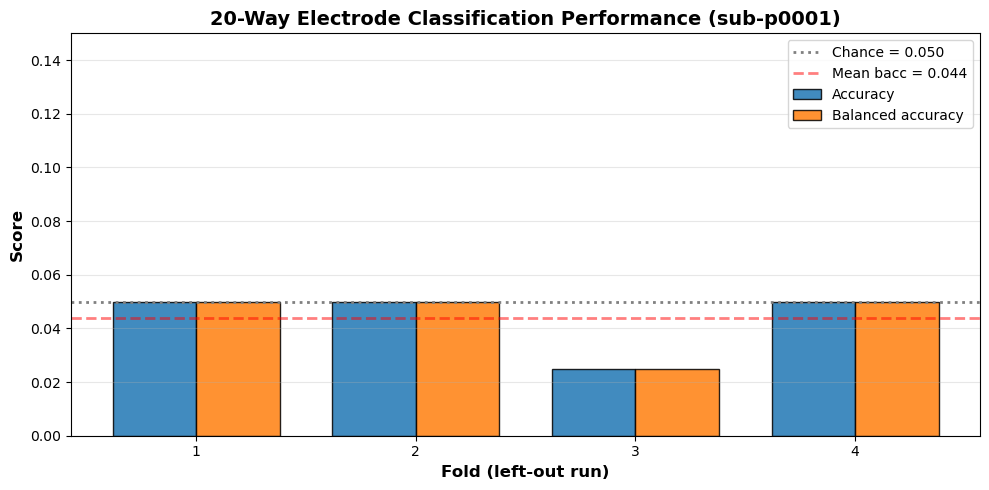

Figure saved to: results\figures\20way_performance.png


In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(1, len(fold_acc) + 1)
width = 0.38

colors_acc = ['#1f77b4']
colors_bacc = ['#ff7f0e']

ax.bar(x - width / 2, fold_acc, width=width, color=colors_acc, alpha=0.85, 
       edgecolor='black', label='Accuracy')
ax.bar(x + width / 2, fold_bacc, width=width, color=colors_bacc, alpha=0.85, 
       edgecolor='black', label='Balanced accuracy')
ax.axhline(chance_level, linestyle=':', linewidth=2, color='gray', 
           label=f'Chance = {chance_level:.3f}')
ax.axhline(mean_bacc, linestyle='--', linewidth=2, color='red', alpha=0.5, 
           label=f'Mean bacc = {mean_bacc:.3f}')

ax.set_xlabel('Fold (left-out run)', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('20-Way Electrode Classification Performance (sub-p0001)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_ylim(0, max(0.15, max(fold_bacc) * 1.15))
ax.grid(axis='y', alpha=0.3)
ax.legend(loc='upper right')
plt.tight_layout()
fig.savefig(FIGURES_DIR / '20way_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {FIGURES_DIR / '20way_performance.png'}")

## Confusion Matrix

PER-ELECTRODE ACCURACY
E1: 0.125
E10: 0.000
E11: 0.000
E12: 0.000
E13: 0.125
E14: 0.000
E15: 0.125
E16: 0.000
E17: 0.000
E18: 0.000
E19: 0.250
E2: 0.000
E20: 0.000
E3: 0.125
E4: 0.125
E5: 0.000
E6: 0.000
E7: 0.000
E8: 0.000
E9: 0.000

Mean per-electrode accuracy: 0.044
Std per-electrode accuracy:  0.072


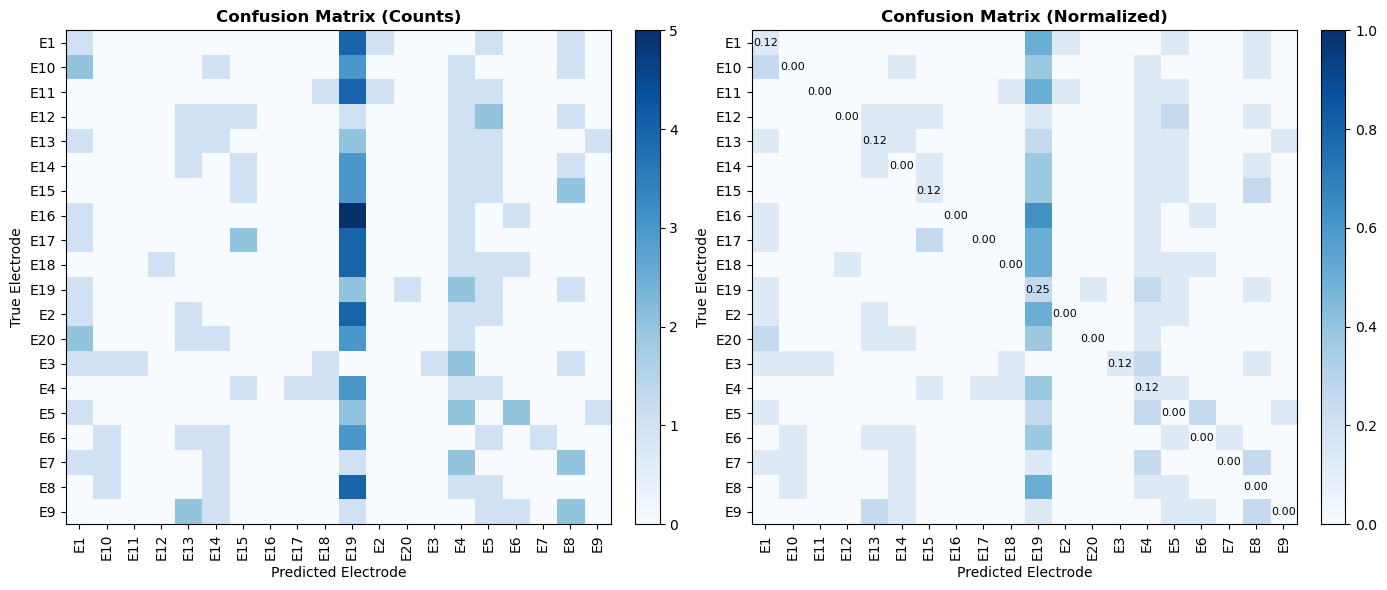


Figure saved to: results\figures\20way_confusion_matrix.png


In [9]:
cm = confusion_matrix(y, y_pred, labels=all_classes)
row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm, np.where(row_sums == 0, 1, row_sums))

per_class_acc = np.diag(cm_norm)
print("=" * 70)
print("PER-ELECTRODE ACCURACY")
print("=" * 70)
for cls, acc in zip(all_classes, per_class_acc):
    print(f"{cls}: {float(acc):.3f}")
print(f"\nMean per-electrode accuracy: {per_class_acc.mean():.3f}")
print(f"Std per-electrode accuracy:  {per_class_acc.std():.3f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im0 = axes[0].imshow(cm, cmap='Blues', aspect='auto')
axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold')
axes[0].set_xticks(np.arange(len(all_classes)))
axes[0].set_yticks(np.arange(len(all_classes)))
axes[0].set_xticklabels(all_classes, rotation=90)
axes[0].set_yticklabels(all_classes)
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(cm_norm, cmap='Blues', aspect='auto', vmin=0, vmax=1)
axes[1].set_title('Confusion Matrix (Normalized)', fontweight='bold')
axes[1].set_xticks(np.arange(len(all_classes)))
axes[1].set_yticks(np.arange(len(all_classes)))
axes[1].set_xticklabels(all_classes, rotation=90)
axes[1].set_yticklabels(all_classes)
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

for i in range(len(all_classes)):
    val = float(cm_norm[i, i])
    color = 'white' if val > 0.5 else 'black'
    axes[1].text(i, i, f"{val:.2f}", ha='center', va='center', fontsize=8, color=color)

for ax in axes:
    ax.set_xlabel('Predicted Electrode')
    ax.set_ylabel('True Electrode')

plt.tight_layout()
fig.savefig(FIGURES_DIR / '20way_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: {FIGURES_DIR / '20way_confusion_matrix.png'}")